# basic-003
https://chatgpt.com/c/680396d9-129c-800a-b753-3b5229e85e6d

In [2]:
# 📦 Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

In [4]:
# 🗂 Load the datasets
data = pd.read_csv("../datasets/XAGUSD-H1-rates.csv", sep=r"\s+")
recent_data = pd.read_csv("../datasets/new-data-for-test/rows-30-from-20240503.csv", sep=r"\s+")

In [5]:
# 🧹 Clean and select relevant columns
use_cols = ["<OPEN>", "<HIGH>", "<LOW>", "<CLOSE>", "<TICKVOL>"]
data = data[use_cols]
recent_data = recent_data[use_cols]

In [6]:
# 🔁 Normalize the data
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)
recent_scaled = scaler.transform(recent_data)

In [7]:
# 🔀 Create sequences
def create_sequences(data, window_size=30):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size])
    return np.array(X), np.array(y)

WINDOW_SIZE = 30
X, y = create_sequences(data_scaled, WINDOW_SIZE)

In [8]:
# ✂️ Split train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
# 🧠 Build LSTM model
model = Sequential([
    LSTM(64, activation='relu', input_shape=(WINDOW_SIZE, X.shape[2])),
    Dense(64, activation='relu'),
    Dense(X.shape[2])  # Predict OHLC + volume
])
model.compile(optimizer='adam', loss='mse')
model.summary()

/home/saeed/repozitories/machine-learning/tensorflow-course/start-tensorflow/envs/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        17,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,405 (87.52 KB)

 Trainable params: 22,405 (87.52 KB)

 Non-trainable params: 0 (0.00 B)

In [10]:
# 🏋️ Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_test, y_test))

Epoch 1/10


2025-04-19 16:26:17.797901: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 26425200 exceeds 10% of free system memory.


689/689 ━━━━━━━━━━━━━━━━━━━━ 20s 25ms/step - loss: 0.0128 - val_loss: 2.4598e-04
Epoch 2/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 18s 26ms/step - loss: 2.0223e-04 - val_loss: 2.3970e-04
Epoch 3/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 17s 25ms/step - loss: 2.0718e-04 - val_loss: 2.2090e-04
Epoch 4/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 17s 25ms/step - loss: 1.8607e-04 - val_loss: 2.3502e-04
Epoch 5/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 17s 25ms/step - loss: 1.9155e-04 - val_loss: 2.2317e-04
Epoch 6/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 19s 28ms/step - loss: 1.9725e-04 - val_loss: 2.0372e-04
Epoch 7/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 22s 32ms/step - loss: 1.8764e-04 - val_loss: 2.6164e-04
Epoch 8/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 22s 33ms/step - loss: 1.8569e-04 - val_loss: 2.0657e-04
Epoch 9/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 22s 33ms/step - loss: 1.7490e-04 - val_loss: 1.8948e-04
Epoch 10/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 22s 32ms/step - loss: 1.6220e-04 - val_loss: 1.9110e-04


In [11]:
# 🔮 Predict 100 future candles
future_input = recent_scaled.copy()
future_predictions = []

for _ in range(100):
    input_seq = future_input[-WINDOW_SIZE:].reshape(1, WINDOW_SIZE, X.shape[2])
    pred = model.predict(input_seq, verbose=0)[0]
    future_predictions.append(pred)
    future_input = np.vstack([future_input, pred])

In [12]:
# 🧾 Inverse transform predictions
all_candles = np.vstack([recent_scaled, np.array(future_predictions)])
all_candles_unscaled = scaler.inverse_transform(all_candles)

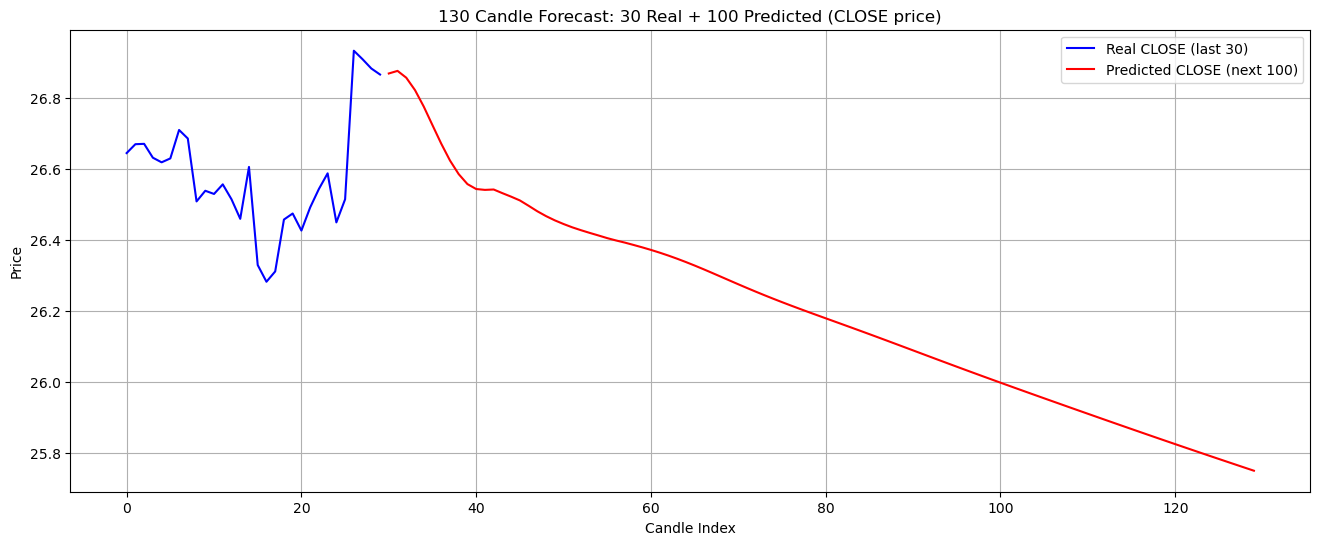

In [13]:
# 📊 Plot real 30 + predicted 100 candles
real_candles = all_candles_unscaled[:30]
predicted_candles = all_candles_unscaled[30:]

plt.figure(figsize=(16, 6))
plt.plot(real_candles[:, 3], label="Real CLOSE (last 30)", color="blue")  # CLOSE is at index 3
plt.plot(np.arange(30, 130), predicted_candles[:, 3], label="Predicted CLOSE (next 100)", color="red")
plt.title("130 Candle Forecast: 30 Real + 100 Predicted (CLOSE price)")
plt.xlabel("Candle Index")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.show()
